In [1]:
import pandas as pd
import numpy as np
import openpyxl

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LinearRegression

import catboost
from catboost import CatBoostRegressor

import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose  # to split the time series into components
import statsmodels.tsa.api as smt
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### Функции 

In [2]:
# Функция для отображения графиков
def show(df, column, color, name):
    fig, ax1 = plt.subplots(figsize=(17,3))
    # plt.xticks(rotation=90, fontsize=8,)

    color_1 = 'tab:grey'
    ax1.plot(df.index, df[column], color=color, label=name, linewidth=3)
    ax1.tick_params(axis='y', labelcolor=color_1)
    ax1.legend()

In [3]:
# Убираем выбросы. Для этого используем фильтр Хэмплея.
# Туториал по ссылке https://habr.com/ru/articles/703246/
def hampel(y, window_size, simg=3):    
    n = len(y)
    new_y = y.copy()
    k = 1.4826
    idx = []

    for i in range((window_size),(n - window_size)):
        r_median = np.median(y[(i - window_size):(i + window_size)]) #скользящая медиана 
        r_mad  = np.median(np.abs(y[(i - window_size):(i + window_size)] - r_median)) #скользящий MAD 
        if (np.abs(y[i] - r_median) > simg * r_mad):
            new_y[i] = r_median #замена выброса
            idx.append(i)
    
    return new_y, idx

In [4]:
# Тест Дики-Фуллера (Dickey-Fuller)
def is_stationary(y):
    # "HO: Non-stationary"  => ряд НЕ является стационарным
    # "H1: Stationary"  => ряд является стационарным
    p_value = sm.tsa.stattools.adfuller(y)[1]
    if p_value < 0.05:
        print(F"Ряд стационарьный, p-value: {round(p_value, 3)}.")
    else:
        print(F"Ряд не является стационарьным, p-value: {round(p_value, 3)}.")

In [5]:
def draw_result(y_test, pred, model):
    
    date_lst = [pd.to_datetime(dat).date() for dat in y_test.index]
    
    fig, ax = plt.subplots(figsize=(17,5))
    
    ax.plot(date_lst, y_test, color='green', linewidth=3)
    ax.plot(date_lst, pred, color='red', linewidth=3)
    
    plt.legend(["Фактическое значение", "Прогноз"], loc="upper right")
    plt.title(model)
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    
    ax.tick_params(axis='x', labelsize=9)
    plt.gcf().autofmt_xdate()
    plt.xticks(rotation = 90) # Поворачиваем надписи

In [6]:
# Функция для вывода ошибок RMSE и MAE
def rmse(fact, pred):
    diff = pred - fact
    different_squares = diff * diff
    mean_diff = different_squares.mean()
    rmse_val = np.sqrt(mean_diff)
    return round(rmse_val, 3)

def get_metrics(fact, pred):
    rmse_val = round(rmse(fact, pred), 3)
    mae_val = round(mean_absolute_error(fact, pred), 3)
    return f'RMSE: {rmse_val}, MAE: {mae_val}'

### **Загрузка данных и их первичный анализ**

In [7]:
df = pd.read_excel('data_for_test.xlsx', index_col=0)

In [8]:
df.head()

,Y,TV,OOH,Seasonal_Sales,Usd_rate,Usd_rate_1000
Date,,,,,,
2013-01-01,NaN,0,0.0,0.060802,30.502001,30502.001
2013-01-02,0.0,0,0.0,0.060802,30.337200,30337.200
2013-01-03,17.0,0,0.0,0.060802,30.156500,30156.500
2013-01-04,17.0,0,0.0,0.060802,30.271000,30271.000
2013-01-05,8.0,0,0.0,0.060802,30.271000,30271.000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 762 entries, 2013-01-01 to 2015-02-01
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Y               759 non-null    float64
 1   TV              762 non-null    int64  
 2   OOH             762 non-null    float64
 3   Seasonal_Sales  762 non-null    float64
 4   Usd_rate        762 non-null    float64
 5   Usd_rate_1000   762 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 41.7 KB


In [10]:
df.isnull().sum()

Y                 3
TV                0
OOH               0
Seasonal_Sales    0
Usd_rate          0
Usd_rate_1000     0
dtype: int64

In [11]:
df[df.isnull().any(axis=1)]

,Y,TV,OOH,Seasonal_Sales,Usd_rate,Usd_rate_1000
Date,,,,,,
2013-01-01,NaN,0,0.0,0.060802,30.502001,30502.001
2014-01-01,NaN,0,0.0,0.060802,32.683201,32683.201
2015-01-01,NaN,0,0.0,0.060802,60.700001,60700.001


**Пропуски присутствуют по переменной Y каждое 1-е января. Во всей стране нерабочий день. Поэтому просто заменим их нулями.**

In [12]:
df.Y['2013-01-01'] = 0.0
df.Y['2014-01-01'] = 0.0
df.Y['2015-01-01'] = 0.0

In [13]:
# Фильтр Ходрика-Прескота для выделения тренда
cycle, trend = sm.tsa.filters.hpfilter(df.Y, 1600)
cycle_season, trend_season = sm.tsa.filters.hpfilter(df.Seasonal_Sales, 1600)

In [14]:
df['Y_Trend'] = trend

In [15]:
# df['Seasonal_Sales_cycle'] = cycle_season

In [16]:
# show(df, 'Seasonal_Sales_cycle', 'red', 'Y_Trend')

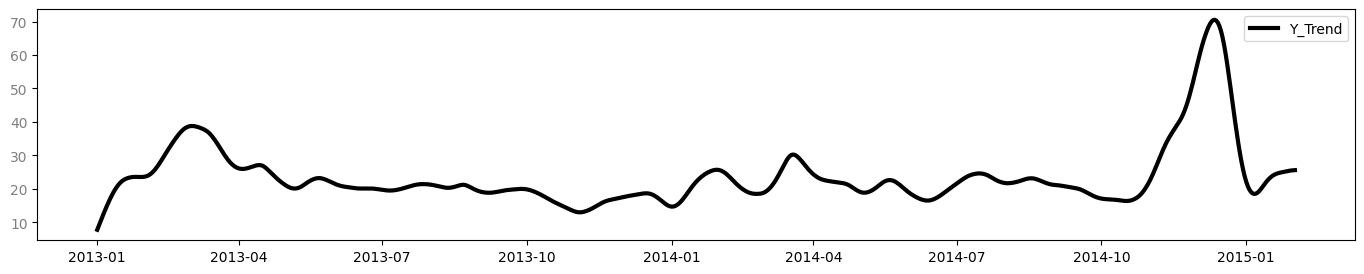

In [17]:
show(df, 'Y_Trend', 'black', 'Y_Trend')

In [18]:
df.describe()

,Y,TV,OOH,Seasonal_Sales,Usd_rate,Usd_rate_1000,Y_Trend
count,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000
mean,23.534121,1040.011811,468.645669,0.460017,36.330886,36330.886382,23.534121
std,15.124434,3645.686335,6208.391584,0.353072,8.022390,8022.389916,9.314858
min,0.000000,0.000000,0.000000,0.000000,29.883301,29883.301000,7.784809
25%,16.000000,0.000000,0.000000,0.062488,32.113201,32113.201000,18.948889
50%,21.000000,0.000000,0.000000,0.360924,33.413300,33413.300000,21.139206
75%,27.000000,0.000000,0.000000,0.759700,36.036124,36036.124500,24.359983
max,176.000000,26310.000000,145137.000000,1.000000,68.735001,68735.001000,70.521493


**Краткий комментарий: данные имеют разнородную структуру. Ежедневный формат имеют только Y и Usr_rate. Seasonal_Sales - месячный формат, растянутый на весь месяц одним значением. OOH - строго месячный формат.**

**Поскольку идентичную периодичность имеют только Y и Usr_rate, посмотрим на них графически на фоне сезонности.**

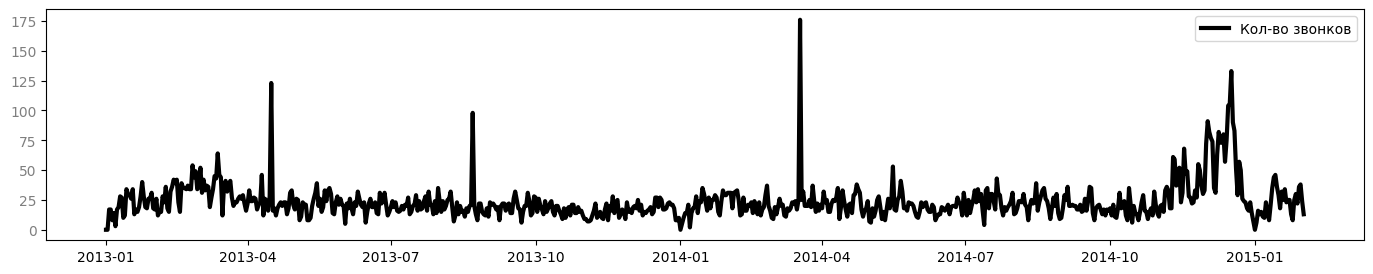

In [19]:
show(df, 'Y', 'black', 'Кол-во звонков')
# show(df, 'Y_Trend', 'red', 'Кол-во звонков')

**В таргете присутствуют выбросы. Их надо устранить. Но, удалять не рекомендуется. Лучше преобразовать. Для этого воспользуюсь фильтром Хэмплея.**

In [20]:
new_y, outliers = hampel(df.Y, 3)

In [21]:
df['Y_outliers'] = new_y

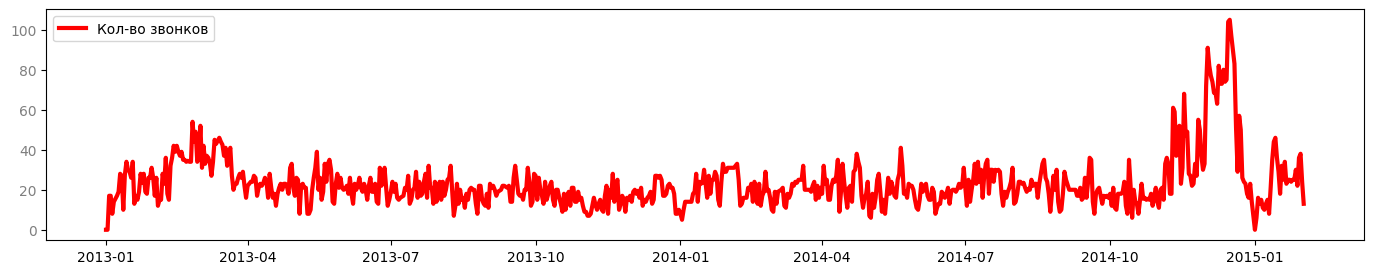

In [22]:
show(df, 'Y_outliers', 'red', 'Кол-во звонков')

Выбросов нет.

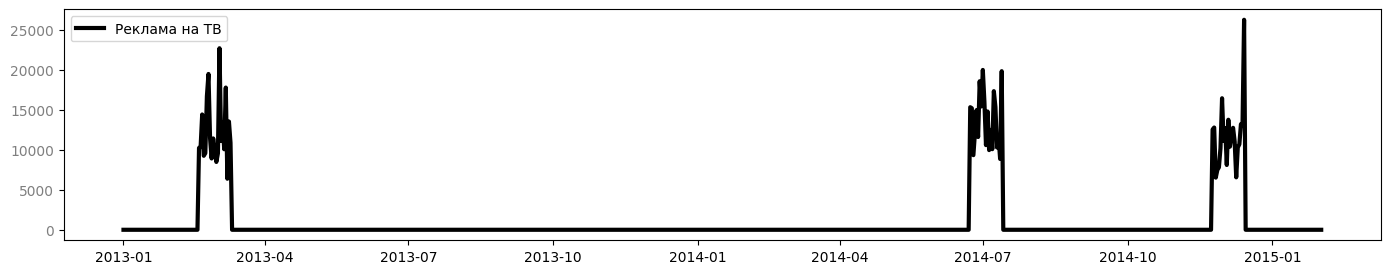

In [23]:
show(df, 'TV', 'black', 'Реклама на ТВ')

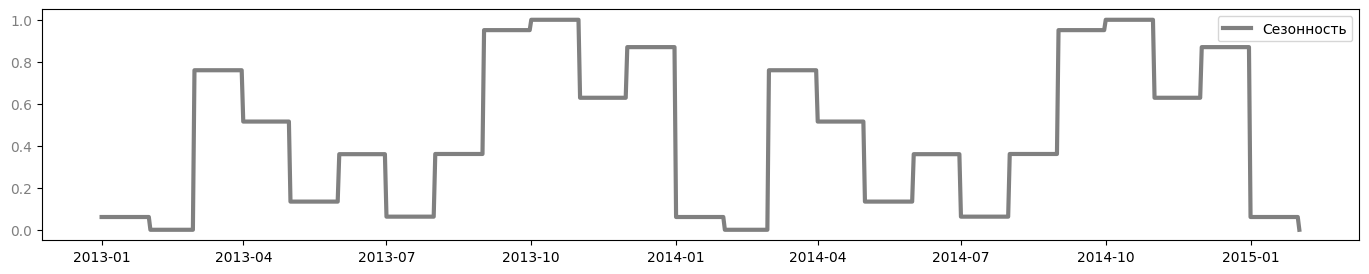

In [24]:
show(df, 'Seasonal_Sales', 'grey', 'Сезонность')

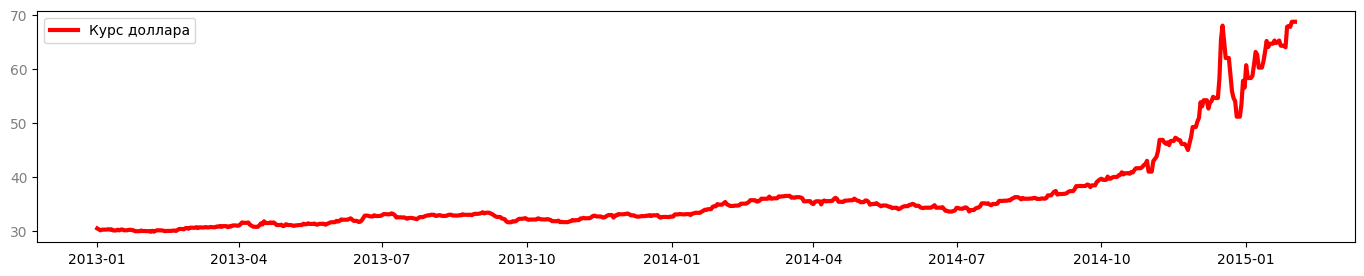

In [25]:
show(df, 'Usd_rate', 'red', 'Курс доллара')

In [26]:
# df['USD_1'] = df.Usd_rate.shift(2)

In [27]:
# df = df[2:]

In [28]:
# df.head()

In [29]:
# df.tail()

**Тест на стационарность**

In [31]:
is_stationary(df.Y_outliers) 
is_stationary(df.Usd_rate)
is_stationary(df.Usd_rate_1000)
is_stationary(df.TV)
is_stationary(df.Seasonal_Sales)

Ряд стационарьный, p-value: 0.002.
Ряд не является стационарьным, p-value: 1.0.
Ряд не является стационарьным, p-value: 1.0.
Ряд стационарьный, p-value: 0.0.
Ряд стационарьный, p-value: 0.038.


Ряд к курсом валют не является стационарным. Нужно его преобразовать.

Ряд стационарьный, p-value: 0.0.
Ряд стационарьный, p-value: 0.0.


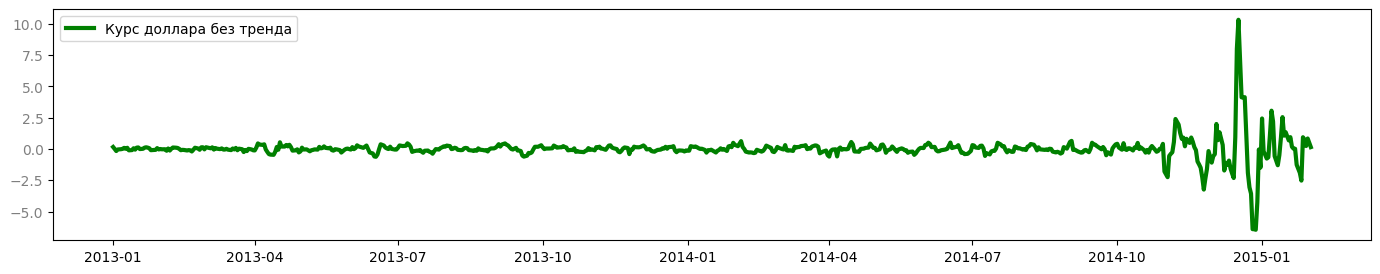

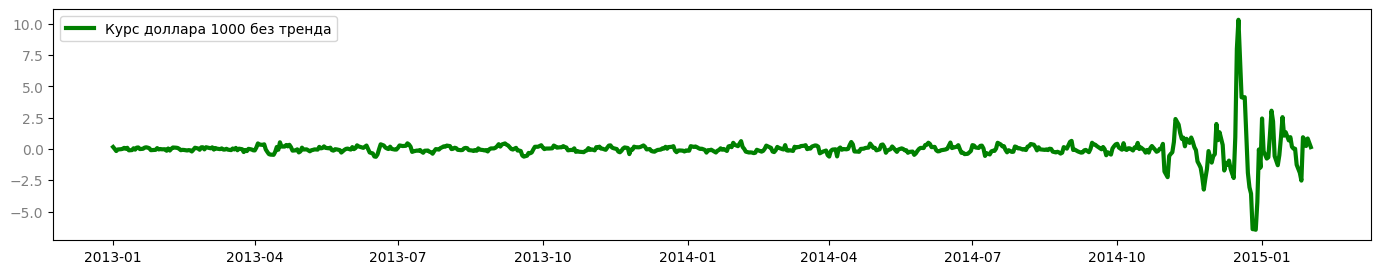

In [32]:
cycle_doll, trend_doll = sm.tsa.filters.hpfilter(df.Usd_rate, 1600)
df['Usd_rate_cycle'] = cycle_doll
show(df, 'Usd_rate_cycle', 'green', 'Курс доллара без тренда')
is_stationary(df.Usd_rate_cycle)

cycle_doll_1000, trend_doll_1000 = sm.tsa.filters.hpfilter(df.Usd_rate_1000, 1600)
df['Usd_rate_cycle_1000'] = cycle_doll_1000
show(df, 'Usd_rate_cycle', 'green', 'Курс доллара 1000 без тренда')
is_stationary(df.Usd_rate_cycle_1000)

<Axes: >

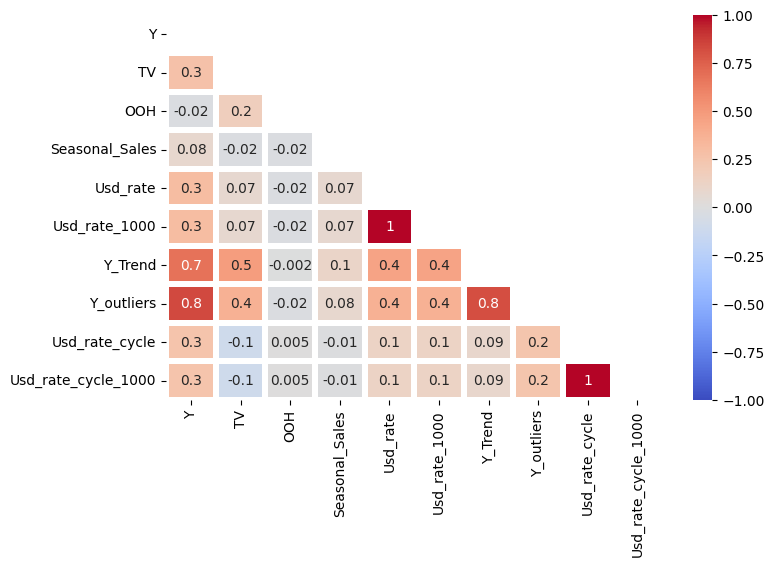

In [33]:
plt.subplots(figsize=(8, 5))
matrix = np.triu(df.corr())
sns.heatmap(df.corr(), annot=True, 
            vmin=-1, vmax=1, center= 0, fmt='.1g', 
            cmap= 'coolwarm', linewidths=3, mask=matrix)

Сильная корреляция между перемеными отсутствует.

***Сделаем 1 лаг для устранения автокорреляции остатков.***

In [34]:
# df_shiht = df[['TV', 'OOH', 'Seasonal_Sales', 'Usd_rate', 'Y_Trend', 'cos',
#        'Y_outliers', 'Usd_rate_cycle']].shift(1)

In [35]:
# df_shiht['Y_outliers'] = df['Y_outliers']

In [36]:
# df_shiht = df_shiht[1:]
# df_shiht

In [37]:
df['Y_outliers_7'] = df['Y_outliers'].shift(7)
# df['Usd_rate_cycle_7'] = df['Usd_rate_cycle'].shift(7)
df['TV_7'] = df['TV'].shift(7)

In [38]:
df = df[7:]

In [39]:
# np.log2(data['Salary'])

y = np.log1p(df.Y_outliers)
X = df.drop('Y_outliers', axis=1)
# X = df.drop('Y_outliers_7', axis=1)
X = X.drop('Y', axis=1)
X = X.drop('Y_Trend', axis=1)
X = X.drop('Usd_rate', axis=1)
# X = X.drop('Usd_rate_cycle', axis=1)
# X = X.drop('cos', axis=1)
X = X.drop('OOH', axis=1)
X = X.drop('Seasonal_Sales', axis=1)
X = X.drop('TV', axis=1)

In [40]:
X.columns

Index(['Usd_rate_1000', 'Usd_rate_cycle', 'Usd_rate_cycle_1000',
       'Y_outliers_7', 'TV_7'],
      dtype='object')

***Выборку делим примерно 80 на 20***

In [95]:
y_train = y[y.index <= pd.to_datetime('11.30.2014')] #'11.30.2014' '12.31.2014' '09.01.2014'
y_test = y[y.index > pd.to_datetime('11.30.2014')]

X_train = X[X.index <= pd.to_datetime('11.30.2014')]
X_test = X[X.index > pd.to_datetime('11.30.2014')]

In [96]:
X_train.head(3)

,Usd_rate_1000,Usd_rate_cycle,Usd_rate_cycle_1000,Y_outliers_7,TV_7
Date,,,,,
2013-01-08,30358.999,0.089163,89.162640,0.0,0.0
2013-01-09,30274.500,0.014810,14.809929,0.0,0.0
2013-01-10,30343.300,0.093739,93.738723,17.0,0.0


In [97]:
ss = StandardScaler()
mm = MinMaxScaler()

In [98]:
# X_train['Y_Trend'] = mm.fit_transform(np.array(X_train['Y_Trend']).reshape(-1, 1))
# X_test['Y_Trend'] = mm.transform(np.array(X_test['Y_Trend']).reshape(-1, 1))

X_train['Usd_rate_cycle'] = mm.fit_transform(np.array(X_train['Usd_rate_cycle']).reshape(-1, 1))
X_test['Usd_rate_cycle'] = mm.transform(np.array(X_test['Usd_rate_cycle']).reshape(-1, 1))

X_train['Usd_rate_cycle_1000'] = mm.fit_transform(np.array(X_train['Usd_rate_cycle_1000']).reshape(-1, 1))
X_test['Usd_rate_cycle_1000'] = mm.transform(np.array(X_test['Usd_rate_cycle_1000']).reshape(-1, 1))

X_train['TV_7'] = mm.fit_transform(np.array(X_train['TV_7']).reshape(-1, 1))
X_test['TV_7'] = mm.transform(np.array(X_test['TV_7']).reshape(-1, 1))

# X_train['OOH'] = mm.fit_transform(np.array(X_train['OOH']).reshape(-1, 1))
# X_test['OOH'] = mm.transform(np.array(X_test['OOH']).reshape(-1, 1))

In [99]:
# X_train_ss = pd.DataFrame(X_train_ss, columns=['TV', 'OOH', 'Seasonal_Sales', 'Usd_rate_without_trend'])
# X_test_ss = pd.DataFrame(X_test_ss, columns=['TV', 'OOH', 'Seasonal_Sales', 'Usd_rate_without_trend'])

# X_train_ss.index = X_train.index
# X_test_ss.index = X_test.index

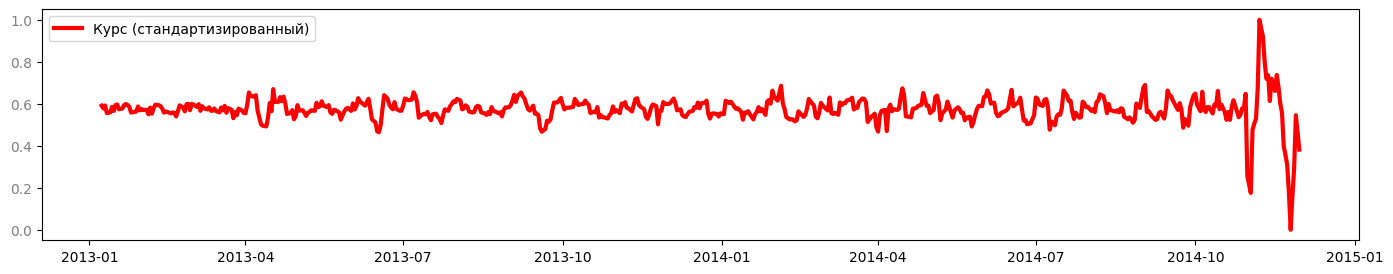

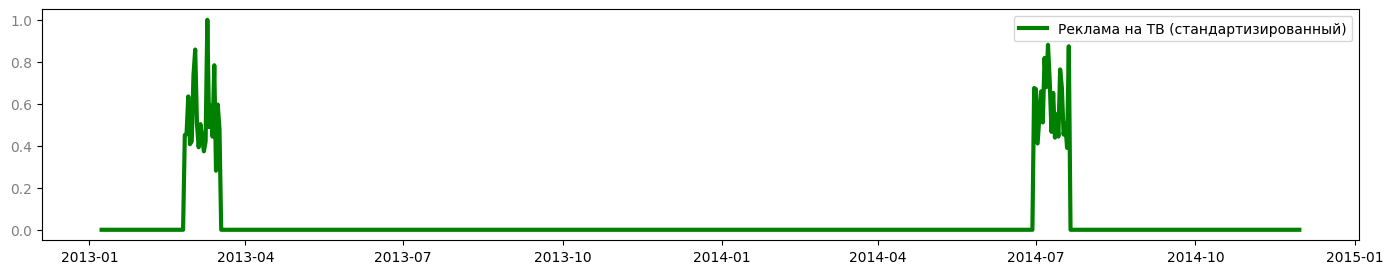

In [100]:
show(X_train, 'Usd_rate_cycle', 'red', 'Курс (стандартизированный)')
show(X_train, 'TV_7', 'green', 'Реклама на ТВ (стандартизированный)')
# show(X_train, 'Seasonal_Sales', 'grey', 'Сезонность (стандартизированный)')
# show(X_train, 'OOH', 'blue', 'Реклама (стандартизированный)')

In [92]:
X_train.columns

Index(['Usd_rate_1000', 'Usd_rate_cycle', 'Usd_rate_cycle_1000',
       'Y_outliers_7', 'TV_7'],
      dtype='object')

In [101]:
X_train.drop('Usd_rate_1000', axis=1, inplace=True)
X_train.drop('Usd_rate_cycle', axis=1, inplace=True)

X_test.drop('Usd_rate_1000', axis=1, inplace=True)
X_test.drop('Usd_rate_cycle', axis=1, inplace=True)

### Моделирование 

Начнем с Catboost, чтобы было с чем сравнить нашу модель линейной регрессии.

In [ ]:
%%time
catboost = CatBoostRegressor(iterations=10000, learning_rate=0.001, depth=9)
catboost.fit(X_train, y_train, verbose=False)
pred_cb = catboost.predict(X_test)

draw_result(y_test, pred_cb, 'CatBoost')
get_metrics(y_test, pred_cb)

In [ ]:
catboost = CatBoostRegressor(iterations=10000, learning_rate=0.001, depth=9)
catboost.fit(X_train, y_train, verbose=False)
pred_cb_train = catboost.predict(X_train)

draw_result(y_train, pred_cb_train, 'CatBoost_train')
# get_metrics(y_train, pred_cb_train)

In [ ]:
len(y_train), len(pred_cb_train)

In [ ]:
get_metrics(y_train, pred_cb_train)

***StatModels (базовая модель)***

In [ ]:
model = sm.OLS(y_train, X_train).fit() #cov_type = "HC0"
pred_regression = model.predict(X_test)

draw_result(y_test, pred_regression, 'Linear Regression (SM)')
print(get_metrics(y_test, pred_regression))

print(model.summary())

Как-то не очень. 

Хотя $ R^2 $ и хороший, но ошибка сильно большая.
Далее добавим const.

In [ ]:
pred_regression_train = model.predict(X_train)
draw_result(y_train, pred_regression_train, 'Linear Regression (SM) on train')
print(get_metrics(y_train, pred_regression_train))

***ЛММР с const***

RMSE: 0.671, MAE: 0.477
                            OLS Regression Results                            
Dep. Variable:             Y_outliers   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     67.27
Date:                Sat, 30 Mar 2024   Prob (F-statistic):           3.75e-38
Time:                        23:06:14   Log-Likelihood:                -209.29
No. Observations:                 692   AIC:                             426.6
Df Residuals:                     688   BIC:                             444.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2

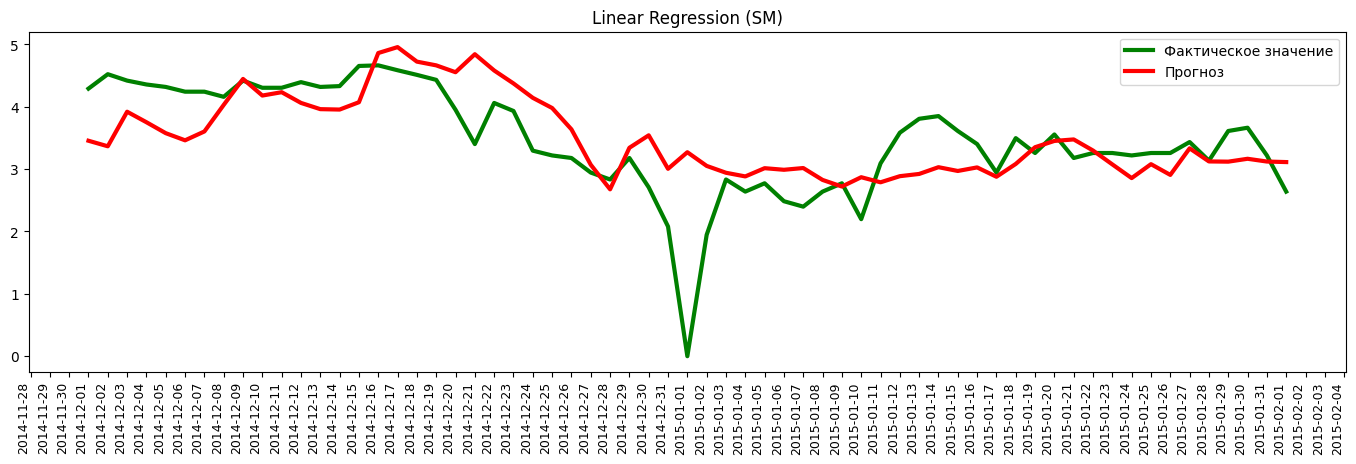

In [85]:
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

model_const = sm.OLS(y_train, X_train_const).fit()
pred_regression_const = model_const.predict(X_test_const)

draw_result(y_test, pred_regression_const, 'Linear Regression (SM)')
print(get_metrics(y_test, pred_regression_const))

print(model_const.summary())

RMSE: 0.671, MAE: 0.477
                            OLS Regression Results                            
Dep. Variable:             Y_outliers   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     67.27
Date:                Sat, 30 Mar 2024   Prob (F-statistic):           3.75e-38
Time:                        23:07:55   Log-Likelihood:                -209.29
No. Observations:                 692   AIC:                             426.6
Df Residuals:                     688   BIC:                             444.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const     

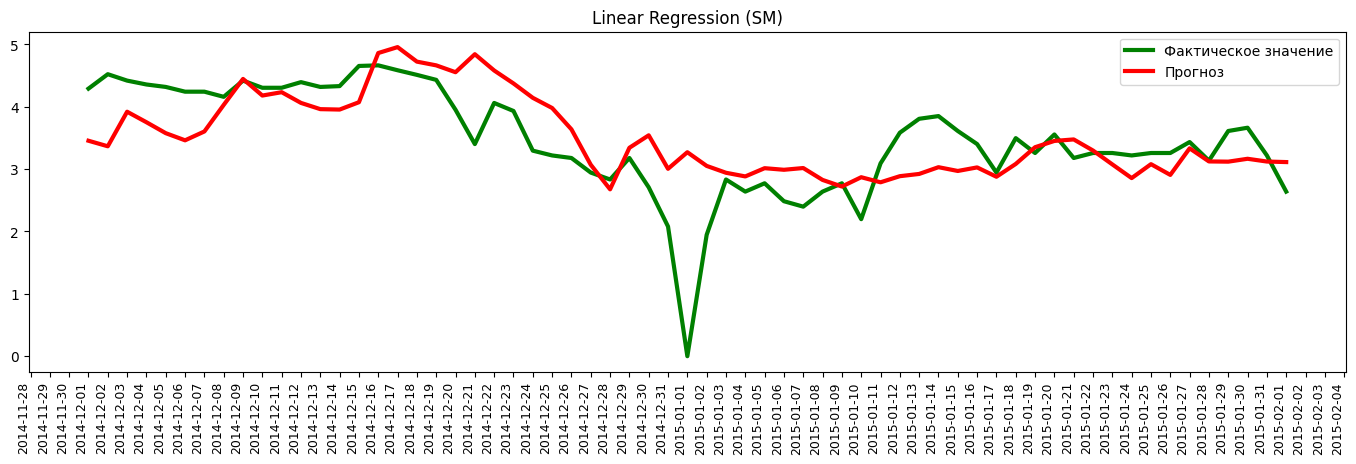

In [102]:
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

model_const = sm.OLS(y_train, X_train_const).fit()
pred_regression_const = model_const.predict(X_test_const)

draw_result(y_test, pred_regression_const, 'Linear Regression (SM)')
print(get_metrics(y_test, pred_regression_const))

print(model_const.summary())

In [ ]:
pred_regression_const_train = model_const.predict(X_train_const)

draw_result(y_train, pred_regression_const_train, 'Linear Regression (SM)')
print(get_metrics(y_train, pred_regression_const_train))

Прогноз стал лучше и превысил ориентир Catboost, но сильно упал $R^2$.

Попробуем еще полиномиальную регрессию.

**Полиномиальная регрессия**

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
poly_reg = PolynomialFeatures(degree = 2)
X_train_poly = sm.add_constant(poly_reg.fit_transform(X_train))
X_test_poly = sm.add_constant(poly_reg.transform(X_test))

In [ ]:
model_poly = sm.OLS(y_train, X_train_poly).fit()
pred_regression = model_poly.predict(X_test_poly)

draw_result(y_test, pred_regression, 'Linear Regression (SM)')
print(get_metrics(y_test, pred_regression))

print(model_poly.summary())

**Качество полиномиальной регрессии по метрикам хуже, чем в линейной с константой.**

**За итоговую модель примем моедель с const.**

### Проверочные тесты модели линейной регрессии c const

**Отсутствие автокорреляции**

In [ ]:
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

In [ ]:
# Perform the Breusch-Godfrey test
bg_test = acorr_breusch_godfrey(model_const, nlags=1)
print(f"Lagrange multiplier statistic: {bg_test[0]}")
print(f"p-value: {bg_test[1]}")
print(f"f-value: {bg_test[2]}")
print(f"f p-value: {bg_test[3]}")

# Plot the ACF of the residuals
plot_acf(model_const.resid)
plt.show()

p-value < 0.05. Автокореляция остатков присутствует.

Далее применим тест Durbin-Watson

In [ ]:
from statsmodels.stats.stattools import durbin_watson
residuals = y_test - pred_regression_const
# Perform Durbin-Watson test

dw_result = durbin_watson(residuals)

print(f'Durbin-Watson statistic: {dw_result}')

В результате мы имеем отрицательную автокорреляцию остатков, т.к. показатель меньше 2.

Для устранения проблемы применено введение лагов. Особых результатов это не дало. 
Как вариант, можно к Y применить метод первых разниц, но это сильно изменит таргет. Поэтому оставим как есть. 

**Тест на наличие гетероскедастичности.**

Забегая вперед, скажу, что гетескедастичность присутствовала. Поэтому пришлось прологарифмировать Y. Это позволило решить проблему.

In [ ]:
from statsmodels. stats.diagnostic import het_white

In [ ]:
#perform White's test
white_test = het_white(model_const. resid , model_const. model.exog )

#define labels to use for output of White's test
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

#print results of White's test
print(dict(zip(labels, white_test)))

**Гетероскетастичность отсутствует.**

**Важный момент:**

имеем 2 модели линейной регрессии. Первая не включает const, а вторая - включает. При этом первая показывает лучшие результаты по коэффициенту дерерминации, но вторая значительно выигрывает в метриках. Поэтому я бы использовал на практике именно ее. 

Справочно: первая модель без const не проходит проверочные тест на автокорреляцию. Тест на гетероскедастичность не применялся ввиду отсутствия const.

### Заключение  

Полученная модель линейной ргегрессии не идеальна. Из основных проблем можно назвать низкий коэффициент детерминации и отрицательный тест на автокорреляцию остатков. При это модель показывает лучшие оценки по метрикам RMSE и MAE. 

Наибольшее влияние на переменную оказывает реклама на ТВ с лагом в 1 неделю и курс доллара (в данном случае лаг отсутствует, а его введение ухудшает качество модели). Определенное влияние на количество продаж оказывает и сезонность. В данном случае она определена как "день к соответствующему дню предыдущей недели" (day to day).

**Как предложение по улучшению модели:** 

Было бы не плохо добавить такую переменную, как,  динамика потребительского кредитования. Я этого не сделал потому, что эта статистика публикуется только с 2018 год. 
Также можно мониторить сайты банков и следить за динамикой процентных ставок по кредитам. Стоимость автомобилей высока, и многие потребители покупали их в кредит даже в то время "благоприятной экономической ситуации".

Возможно, повысить качество модели помог бы такой показатель, как инфляционные ожидания населения (ежемесячно публикуется на сайте ЦБ). Потому что многие потребители склонны под эмоциональным давлением покупать товары сейчас, пусть даже в кредит, ожидая роста цены в будущем. Как показывает практика, такая тенденция наиболее применима именно к авторынку. Следовательно, выше инфляционные ожидания - больше звонков в автосалоны.